# Transfer learning: feature extraction and fine-tuning a pre-trained model

Created by Dr Ana Matran-Fernandez (amatra@essex.ac.uk) for CE888 (Data Science and Decision Making)

This notebook contains the starter code and instructions for lecture 9 and illustrates how to freeze layers from a pre-trained neural network so you can use it to either fine-tune it or as a feature extractor for your own problem.

#### ***Make sure you change the Runtime to GPU on Colab or training will take ages!***

# Imports

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Tensorflow imports
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
# VGG 16
from tensorflow.keras.applications import VGG16

# Dataset prep

We'll be working with the CIFAR10 dataset that we used in the CNN lab.

In [ ]:
dataset = tf.keras.datasets.cifar10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

(train_images0, train_labels0), (test_images0, test_labels0) = dataset.load_data()

print('Train: X=%s, y=%s' % (train_images0.shape, train_labels0.shape))
print('Test: X=%s, y=%s' % (test_images0.shape, test_labels0.shape))

train_labels = train_labels0.reshape(-1)
test_labels = test_labels0.reshape(-1)

num_classification_categories = len(class_names)
print('Number of classes=%d' % num_classification_categories)

In [ ]:
# As we did in the CNN lab, we can plot a few images to get an idea of what the dataset looks like
plt.figure(figsize=(10,10))
for i in range(25):
    # define subplot
    plt.subplot(5,5,i+1)
    # plot raw pixel data
    plt.imshow(train_images0[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if class_names != None:
        # Add a label underneath, if we have one...
        plt.xlabel(class_names[train_labels[i]])
plt.show()

In [ ]:
# Prep the data

# Since we are going to work with VGG16, we note from the documentation that the images need to be preprocessed differently to how we did previously
train_images = tf.keras.applications.vgg19.preprocess_input(train_images0)
test_images = tf.keras.applications.vgg19.preprocess_input(test_images0)

print(train_images.shape, test_images.shape)

input_shape = train_images.shape[1:]

# Feature extraction

Remember that for feature extraction we will load the model and keep the convolutional part, adding only the classifier at the end.

We're going to load the VGG16 architecture pretrained with the ImageNET dataset. We will freeze all the convolutional layers (this means that when we train our model we won't be updating the weights for this layers) and add some dense layers at the top to perform classification on the CIFAR10 dataset.

### **YOUR TASK**

The model I'm giving you is overfitting a lot.
You need to make sure this doesn't happen in your final submission.


# Feature extraction

Remember that for feature extraction we will load the model and keep the convolutional part, adding only the classifier at the end.

We're going to load the VGG16 architecture pretrained with the ImageNET dataset. We will freeze all the convolutional layers (this means that when we train our model we won't be updating the weights for this layers) and add some dense layers at the top to perform classification on the CIFAR10 dataset.

### **YOUR TASK**

The model I'm giving you is overfitting a lot.
You need to make sure this doesn't happen in your final submission.


In [ ]:
# We specify the shape of our inputs
input = layers.Input(shape=input_shape)

model_ = VGG16(weights='imagenet', include_top=False, input_tensor=input)
# include_top=False means that we exclude the last (top) layers 
# (which are responsible for classifying ImageNET)
# So we're only loading the convolutional part of the network (see summary below)
model_.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Note that if we wanted to use some other type of classifier, we can extract the outputs from the model above directly as:

```
features_training = model.predict(train_images)
features_test = model.predict(test_images)
# And now we train our own classifier using these!
clf = ...
clf.fit(features_training, train_labels)
y_pred = clf.predict(features_test)
```



In [ ]:
# We now freeze all the layers so that we only need to append our classifier at the top (bottom in the summary)
for layer in model_.layers: 
  layer.trainable = False

# Use the generated model 
last_layer = model_.output  # these are the features!

In [ ]:
# Now we are going to add the fully connected layers onto the model.
x = layers.Flatten()(last_layer)

# Add fully-connected layers for classification (remember that we need to flatten the features first)
# TO DO: THIS IS OUR CLASSIFIER. WITH THE CONFIGURATION I'M GIVING YOU, YOUR MODEL WILL OVERFIT TERRIBLY. YOUR JOB IS TO EDIT THESE LAYERS SO THAT THE VALIDATION ACCURACY IS >0.65 AND THERE'S NO OVERFITTING
# HINTS: add a Dropout layer between 'fc1' and 'fc2' and reduce the number of neurons in  'fc1'.
# ----- beginning of classifier
x = layers.Dense(1024, activation='relu', name='fc1')(x)
x = layers.Dense(128, activation='relu', name='fc2')(x)
# ----- end of classifier

prediction = layers.Dense(num_classification_categories, activation='softmax')(x)

# What does the model look like now?
model = models.Model(inputs=input, outputs=prediction)
model.summary()  # TO DO:  you will need this for the Moodle quiz

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer=keras.optimizers.Adam(), 
                 metrics=['accuracy'])

my_callbacks = [ModelCheckpoint(filepath='vgg16_model_featureExtraction.h5', save_best_only=True)]  # DON'T CHANGE THIS LINE

# You can change the number of epochs, batch_size...
history = model.fit(train_images, train_labels, batch_size=64,
                       epochs=10,
                       validation_data=(test_images, test_labels),
                       callbacks=my_callbacks)
np.save('history_featureExtraction.npy', [history.history['accuracy'], history.history['val_accuracy']])  # DON'T CHANGE THIS LINE; you'll need this for the Moodle quiz

Epoch 1/10
782/782 [==============================] - 33s 41ms/step - loss: 1.3443 - accuracy: 0.5818 - val_loss: 1.0369 - val_accuracy: 0.6490
Epoch 2/10
782/782 [==============================] - 31s 40ms/step - loss: 0.9237 - accuracy: 0.6805 - val_loss: 0.9957 - val_accuracy: 0.6609
Epoch 3/10
782/782 [==============================] - 31s 39ms/step - loss: 0.7947 - accuracy: 0.7226 - val_loss: 1.0112 - val_accuracy: 0.6621
Epoch 4/10
782/782 [==============================] - 31s 39ms/step - loss: 0.6861 - accuracy: 0.7617 - val_loss: 1.0589 - val_accuracy: 0.6604
Epoch 5/10
782/782 [==============================] - 31s 39ms/step - loss: 0.5776 - accuracy: 0.7955 - val_loss: 1.0875 - val_accuracy: 0.6677
Epoch 6/10
782/782 [==============================] - 31s 39ms/step - loss: 0.4865 - accuracy: 0.8287 - val_loss: 1.2071 - val_accuracy: 0.6636
Epoch 7/10
782/782 [==============================] - 31s 39ms/step - loss: 0.3942 - accuracy: 0.8618 - val_loss: 1.2952 - val_accuracy:

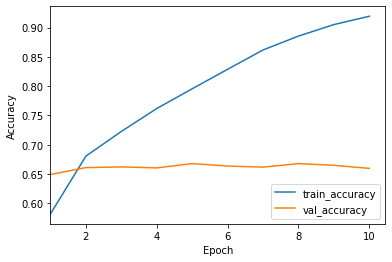

In [ ]:
# Have a look at the training graphs. When your model no longer overfits and your validation accuracy is above 0.65, you can upload it to the Moodle quiz.

epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([1, None])
plt.legend(loc='lower right')


# Fine-tuning

We will now test a second approach to transfer learning: fine-tuning.
Instead of freezing all the convolutional layers, now we'll train the top ones together with the classifier.

### **YOUR TASK**

Same as before, make sure your model isn't overfitting and you can achieve an accuracy on the validation set above 0.8.


In [ ]:
# We specify the shape of our inputs
input = layers.Input(shape=input_shape)

# Load VGG16 again
model_ = VGG16(weights='imagenet', include_top=False, input_tensor=input)
#print(model_.summary())

In [ ]:
# get last layer so we can add our classifier on top again
last_layer = model_.output
# Flatten
x = layers.Flatten()(last_layer)

# Add your classifier
# ----- beginning of classifier
# TO DO: COPY HERE THE CLASSIFIER CONFIGURATION THAT WORKED FOR YOU IN THE FEATURE EXTRACTION TASK
# ----- end of classifier

prediction = layers.Dense(num_classification_categories, activation='softmax')(x)

# Create model
model = models.Model(input, prediction)

print(model.summary())


In [ ]:
# We first need to freeze all the layers except for our classifier (as we did for the feature extraction approach)

# Choose the layers which are updated while training
LAYERS_TO_FREEZE = len(model_.layers)  # DON'T CHANGE THIS
for layer in model.layers[:LAYERS_TO_FREEZE]:
	layer.trainable = False
for layer in model.layers[LAYERS_TO_FREEZE:]:
  layer.trainable = True

for i, layer in enumerate(model.layers):
  print(layer.name, layer.trainable)

In [ ]:
# Train the model (remember that for now we're only training the top layers -- i.e., the ones closest to the output, not the convolutional part!)

# For this first part we train for a few epochs only

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

my_callbacks = [ModelCheckpoint(filepath='vgg16_model_fineTuning.h5', save_best_only=True)]  # don't change this line

history = model.fit(train_images, train_labels, 
                    batch_size=16,
                    epochs=5,  # this number should be small-ish
                    validation_data=(test_images, test_labels),
                    callbacks=my_callbacks)

np.save('history_fineTuning_1.npy', [history.history['accuracy'], history.history['val_accuracy']])  # don't change this line

In [ ]:
# Now that we've done some training on the top layers, we can now do the fine-tuning on the earlier layers

# We will now freeze the bottom LAYERS_TO_FREEZE layers and train the remaining top layers

LAYERS_TO_FREEZE = len(model_.layers)  # TODO: CHANGE THIS NUMBER
for layer in model.layers[:LAYERS_TO_FREEZE]:
	layer.trainable = False
for layer in model.layers[LAYERS_TO_FREEZE:]:
  layer.trainable = True

for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

In [ ]:
# We recompile the model (or the lines above won't have any effect)
# and re-train
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              metrics=['accuracy'])

# add an early stopping callback here (but don't modify the model checkpoint line!)
my_callbacks = [ModelCheckpoint(filepath='vgg16_model_fineTuning.h5', save_best_only=True),
                ]

# Train again
history = model.fit(train_images, train_labels, 
                    batch_size=16,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=my_callbacks)
np.save('history_fineTuning_2.npy', [history.history['accuracy'], history.history['val_accuracy']])  # don't change this line

In [ ]:
# Have a look at the training graphs. 
# When your validation accuracy is >0.8, you can upload it to the Moodle quiz.

epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([1, None])
plt.legend(loc='lower right')